# Path Finder

In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
from shapely import LineString, Point
import matplotlib.pyplot as plt
import momepy
import networkx as nx
import osmnx  as ox

/var/folders/bh/hhr2wkwn2ldcpz5w4tgn7sb80000gn/T/ipykernel_93818/3393949879.py:1: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


# 1. Load data & apply projection

Load stations

In [2]:
stations = gpd.read_parquet('../../data/atom/stations.parquet')
stations.head()

,id,station,netbeheerder,status,totaleCapaciteitInvoedingMva,totaleCapaciteitAfnameMva,beschikbareCapaciteitInvoedingHuidigMva,beschikbareCapaciteitAfnameHuidigMva,verwachtJaarVanOverbelastingInvoeding,verwachtJaarVanOverbelastingAfname,...,peildatum,beschikbareCapaciteitAfname3JaarMvaVisualisatie,beschikbareCapaciteitAfname5JaarMvaVisualisatie,beschikbareCapaciteitAfname10JaarMvaVisualisatie,beschikbareCapaciteitAfnameHuidigMvaVisualisatie,beschikbareCapaciteitInvoeding3JaarMvaVisualisatie,beschikbareCapaciteitInvoeding5JaarMvaVisualisatie,beschikbareCapaciteitInvoeding10JaarMvaVisualisatie,beschikbareCapaciteitInvoedingHuidigMvaVisualisatie,geometry
0,stations.34bda653-e4ae-4a3b-9399-c59f9f730745,Krimpen_Langeland 50 kV,Stedin,Bestaand,117.0,117.0,142.0,12.0,2050,2026,...,2022-10-18,0,0,0,12,0,0,0,142,POINT (4.62915 51.91080)
1,stations.b3b5f7d2-8fb9-4b44-9fe8-cdecd171eceb,Rotterdam Ommoord 25 kV,Stedin,Bestaand,115.0,115.0,157.0,-30.0,2050,2050,...,2022-10-18,0,0,0,0,149,148,142,157,POINT (4.52947 51.95541)
2,stations.57fc548f-9089-4e24-ab62-7555f0035b4b,Gouda Ijsseldijk 50 kV,Stedin,Bestaand,200.0,200.0,185.0,48.0,2045,2035,...,2022-10-18,22,13,0,48,203,176,121,185,POINT (4.73411 52.00775)
3,stations.600e067d-26f2-4f1a-944b-54d47534ba72,Delft 1 25 kV,Stedin,Bestaand,187.0,187.0,205.0,46.0,2050,2027,...,2022-10-18,15,4,0,46,201,191,160,205,POINT (4.36754 51.98904)
4,stations.5c7d27cc-871e-4c39-aa64-2186cb674d25,Grindweg 25 kV,Stedin,Bestaand,40.0,40.0,48.0,5.0,2050,2026,...,2022-10-18,3,0,0,5,38,36,30,48,POINT (4.49639 51.96228)


Load segments

In [3]:
verzorgingsgebied = gpd.read_parquet('../../data/atom/verzorgingsgebied.parquet')
verzorgingsgebied = verzorgingsgebied.to_crs(stations.crs)
verzorgingsgebied.head()

,id,station,netbeheerder,status,totaleCapaciteitInvoedingMva,totaleCapaciteitAfnameMva,beschikbareCapaciteitInvoedingHuidigMva,beschikbareCapaciteitAfnameHuidigMva,verwachtJaarVanOverbelastingInvoeding,verwachtJaarVanOverbelastingAfname,...,peildatum,beschikbareCapaciteitAfname3JaarMvaVisualisatie,beschikbareCapaciteitAfname5JaarMvaVisualisatie,beschikbareCapaciteitAfname10JaarMvaVisualisatie,beschikbareCapaciteitAfnameHuidigMvaVisualisatie,beschikbareCapaciteitInvoeding3JaarMvaVisualisatie,beschikbareCapaciteitInvoeding5JaarMvaVisualisatie,beschikbareCapaciteitInvoeding10JaarMvaVisualisatie,beschikbareCapaciteitInvoedingHuidigMvaVisualisatie,geometry
0,indicatief_verzorgingsgebied.3f7b1732-778d-4b1...,Wittevrouweveld,Enexis,Bestaand,35,35,34.0,10.0,2028,2035,...,2022-12-14,10,10,10,10,34,34,34,34,"MULTIPOLYGON (((5.66455 50.83226, 5.70274 50.8..."
1,indicatief_verzorgingsgebied.0a727e27-ba60-487...,Boschpoort,Enexis,Bestaand,45,45,6.0,23.0,2023,2035,...,2022-12-14,23,23,23,23,6,6,6,6,"MULTIPOLYGON (((5.64897 50.82704, 5.64918 50.8..."
2,indicatief_verzorgingsgebied.ed973a51-edcc-40e...,Heer,Enexis,Bestaand,40,40,38.0,0.0,2028,2023,...,2022-12-14,0,0,0,0,38,38,38,38,"MULTIPOLYGON (((5.83113 50.75886, 5.83102 50.7..."
3,indicatief_verzorgingsgebied.9e164099-7d30-41a...,Schoonbron,Enexis,Bestaand,45,47,0.0,0.0,2023,2023,...,2022-12-14,0,0,0,0,0,0,0,0,"MULTIPOLYGON (((5.91508 50.75040, 5.91508 50.7..."
4,indicatief_verzorgingsgebied.adc9060f-a6b2-4dd...,Terwinselen,Enexis,Bestaand,110,116,0.0,0.0,2023,2023,...,2022-12-14,0,0,0,0,0,0,0,0,"MULTIPOLYGON (((6.05465 50.92368, 6.05450 50.9..."


Load low voltage cables (LVC) network

In [4]:
laagspanningskabel = gpd.read_parquet('../../data/liander/laagspanningskabels.pyarrow')
laagspanningskabel = laagspanningskabel.to_crs(stations.crs)
laagspanningskabel.head()

,id,geometry
0,3337146,"LINESTRING (5.70785 51.95208, 5.70783 51.95208..."
1,3337161,"LINESTRING (5.70684 51.95345, 5.70683 51.95343..."
2,3337172,"LINESTRING (5.70719 51.95240, 5.70719 51.95240..."
3,3337187,"LINESTRING (5.70743 51.95292, 5.70740 51.95293..."
4,3337202,"LINESTRING (5.70761 51.95377, 5.70760 51.95377..."


Load reconstructed network LVC

In [5]:
reconstructed_lines = gpd.read_parquet('reconstructed_lines_msi_lsv.pyarrow')
reconstructed_lines = reconstructed_lines.to_crs(stations.crs)
reconstructed_lines.head()

,geometry
0,"LINESTRING (6.48067 51.87102, 6.48077 51.87102)"
1,"LINESTRING (6.48066 51.87102, 6.48077 51.87102)"
2,"LINESTRING (6.48066 51.87102, 6.48077 51.87102)"
3,"LINESTRING (6.02790 51.95575, 6.02801 51.95570)"
4,"LINESTRING (6.02790 51.95575, 6.02801 51.95570)"


Merge laagspanningskabel and reconstructed_lines geo data

In [6]:
full_laagspanningskabel = pd.concat([laagspanningskabel.geometry, reconstructed_lines.geometry])
full_laagspanningskabel.head()

0    LINESTRING (5.70785 51.95208, 5.70783 51.95208...
1    LINESTRING (5.70684 51.95345, 5.70683 51.95343...
2    LINESTRING (5.70719 51.95240, 5.70719 51.95240...
3    LINESTRING (5.70743 51.95292, 5.70740 51.95293...
4    LINESTRING (5.70761 51.95377, 5.70760 51.95377...
Name: geometry, dtype: geometry

In [7]:
# middenpanningskabel = gpd.read_parquet('../../data/liander/middenspanningskabels.pyarrow')
# middenpanningskabel = middenpanningskabel.to_crs(stations.crs)
# middenpanningskabel.head()

## 1.1 Construct an Address as Point and obtain 3 nearest Stations

Construct Address

In [7]:
address = Point(4.903855, 52.370144) #Nieuwe Uilenburgerstraat 106, 1011 LX Amsterdam, Nederland
address = Point(4.905491204911459, 52.37134366862383)
address = Point(4.9027736698583855, 52.37188903439234)
address = Point(4.9027736698583855, 52.37188903439234) # test data from Richard
# address = Point(4.882221, 52.358489) #Museumplein, Amsterdam, Noord-Holland, Nederland

Retrieve nearest 3 stations

In [8]:
closest_num = 3
destination_stations_idx = address.distance(stations.geometry).sort_values()[:closest_num].index
destination_stations = stations.iloc[destination_stations_idx, :]
destination_stations_names = np.array(destination_stations.station)
destination_segments = verzorgingsgebied[verzorgingsgebied.station.isin(destination_stations_names)]

## 1.2 Plot the 3 Station candidates

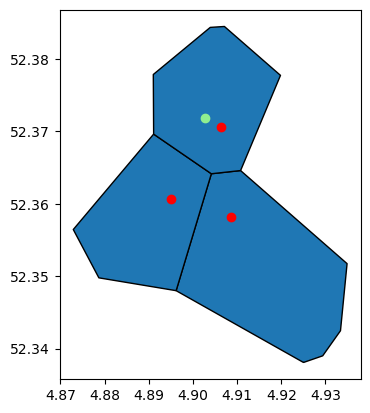

In [9]:
address_gdp = gpd.GeoDataFrame({
    'id': [1],
    'station': ['Address'],
    'netbeheerder': ['Liander']
}, geometry=[address], crs=laagspanningskabel.crs)

fig, ax = plt.subplots()

destination_segments.plot(ax=ax, edgecolor='black')
destination_stations.plot(ax=ax, color='red')
address_gdp.plot(ax=ax, color='lightgreen');

Obtain laagspanningskabels represented within the segments

In [10]:
%%time

segment_x_netten = []

for idx, segment in destination_segments.iterrows():
    inter_idx = segment.geometry.intersects(full_laagspanningskabel.geometry)
    segment_x_netten.append(full_laagspanningskabel[inter_idx])

segment_x_netten = pd.concat(segment_x_netten)

/opt/homebrew/Caskroom/miniforge/base/envs/tenet-challenge/lib/python3.10/site-packages/pandas/core/arraylike.py:495: RuntimeWarning: invalid value encountered in intersects
  return getattr(ufunc, method)(*new_inputs, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/tenet-challenge/lib/python3.10/site-packages/pandas/core/arraylike.py:495: RuntimeWarning: invalid value encountered in intersects
  return getattr(ufunc, method)(*new_inputs, **kwargs)


CPU times: user 37 s, sys: 744 ms, total: 37.8 s
Wall time: 37.8 s


/opt/homebrew/Caskroom/miniforge/base/envs/tenet-challenge/lib/python3.10/site-packages/pandas/core/arraylike.py:495: RuntimeWarning: invalid value encountered in intersects
  return getattr(ufunc, method)(*new_inputs, **kwargs)


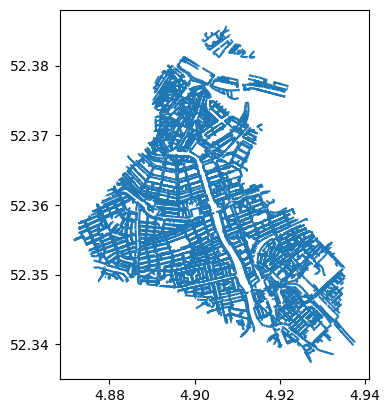

In [11]:
segment_x_netten.plot();

## 1.3 Transform obtained laagspanningskabels to a graph

In [13]:
segment_x_netten = segment_x_netten.reset_index().rename(columns={'index':'id'})
segment_x_netten.head()

,id,id,geometry
0,0,402424,"LINESTRING (4.90363 52.34806, 4.90363 52.34806)"
1,1,402427,"LINESTRING (4.90368 52.34791, 4.90369 52.34791..."
2,2,402429,"LINESTRING (4.91150 52.35175, 4.91150 52.35175..."
3,3,402431,"LINESTRING (4.90227 52.35441, 4.90227 52.35441..."
4,4,402435,"LINESTRING (4.90763 52.35768, 4.90762 52.35768)"


Construct a Primal Graph allowing for the creation of NetworkX MultiGraph that offers path calculation

In [14]:
%%time

G = momepy.gdf_to_nx(segment_x_netten, approach="primal", length='length')

/opt/homebrew/Caskroom/miniforge/base/envs/tenet-challenge/lib/python3.10/site-packages/momepy/utils.py:247: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_network[length] = gdf_network.geometry.length


CPU times: user 480 ms, sys: 157 ms, total: 637 ms
Wall time: 795 ms


Store node positions as dictionary

In [15]:
positions = {n: [n[0], n[1]] for n in list(G.nodes)}

In [167]:
middenspanningsinstallaties = gpd.read_parquet('../../data/liander/middenspanningsinstallaties.pyarrow')
middenspanningsinstallaties = middenspanningsinstallaties.to_crs(stations.crs)
middenspanningsinstallaties.head()

,id,geometry
0,816065352,POINT (6.48077 51.87102)
1,817834249,POINT (5.98052 51.83813)
2,843702200,POINT (6.02801 51.95570)
3,853890452,POINT (5.97804 52.23576)
4,854598048,POINT (5.45366 52.97253)


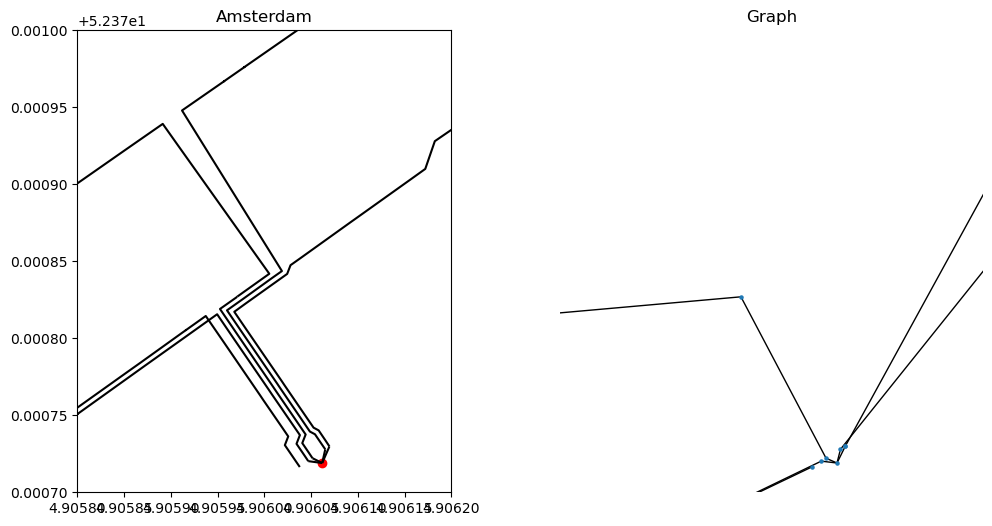

In [17]:
f, ax = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
segment_x_netten.plot(color="k", ax=ax[0])
middenspanningsinstallaties.plot(color='red', ax=ax[0])

for i, facet in enumerate(ax):
    facet.set_title(("Amsterdam", "Graph")[i])
    # facet.axis("off")

ax[1].set_ylim(52.3707, 52.371)
ax[1].set_xlim(4.9058, 4.9062)

nx.draw(G, positions, ax=ax[1], node_size=5)

Obtain nodes and edges

In [18]:
nodes, edges, W = momepy.nx_to_gdf(G, spatial_weights=True, nodeID='osmid')

/opt/homebrew/Caskroom/miniforge/base/envs/tenet-challenge/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 640 disconnected components.
  warnings.warn(message)


In [19]:
G_nx = nx.MultiGraph(name='Amsterdam', crs=edges.crs)

In [20]:
nodes['x'] = nodes.geometry.apply(lambda x: x.coords[0][0])
nodes['y'] = nodes.geometry.apply(lambda x: x.coords[0][1])

In [21]:
%%time

for nodeId, data in nodes.T.to_dict().items():
    G_nx.add_node(nodeId, **data)

for i, row  in edges.iterrows():
    dict_row  = row.to_dict()
    if 'geometry' in dict_row: del dict_row['geometry']
    G_nx.add_edge(u_for_edge=dict_row['node_start'], v_for_edge=dict_row['node_end'], **dict_row)

CPU times: user 997 ms, sys: 12.6 ms, total: 1.01 s
Wall time: 1.01 s


Plot the Graph

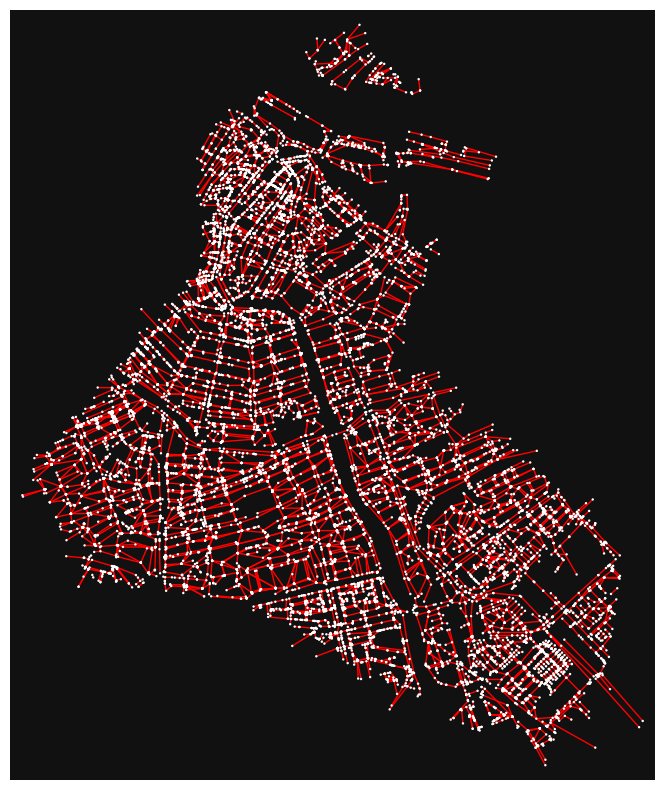

In [23]:
size = 10
ox.plot_graph(G_nx, figsize=(size, size), edge_color='red', node_color='white', node_size=3, filepath='graph.png', save=False);

Define Origin and Destinations

In [24]:
origin = address_gdp
destinations = destination_stations

In [25]:
edges.columns

Index(['id', 'geometry', 'length', 'node_start', 'node_end'], dtype='object')

Find the closest edge to the origin node

In [26]:
closest_edge_idx = edges.distance(origin.iloc[0, -1]).sort_values().reset_index().iloc[0, 0] # much more accurate
closest_edge = edges.iloc[closest_edge_idx, :]
closest_edge

/var/folders/bh/hhr2wkwn2ldcpz5w4tgn7sb80000gn/T/ipykernel_65070/3852200898.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  closest_edge_idx = edges.distance(origin.iloc[0, -1]).sort_values().reset_index().iloc[0, 0] # much more accurate


id                                                       493393
geometry      LINESTRING (4.90241031373798 52.3715643078345,...
length                                                  0.00117
node_start                                                11446
node_end                                                  11822
Name: 11606, dtype: object

Obtain the start node of the closest edge to the origin

In [37]:
start_node = nodes.iloc[closest_edge.node_start, :]
closest_origin_node_idx = nodes.iloc[closest_edge.node_start, 0]
start_node

osmid                                             11446
geometry    POINT (4.903238769977337 52.37163330718491)
x                                              4.903239
y                                             52.371633
Name: 11446, dtype: object

In [35]:
# closest_origin_node_idx = ox.nearest_edges(G=G_nx, X=origin.geometry.x, Y=origin.geometry.y)[0][0]
# closest_origin_node_idx = ox.nearest_nodes(G=G_nx, X=origin.geometry.x, Y=origin.geometry.y)[0]
# nodes.loc[closest_origin_node_idx]

In [39]:
# edges[(edges.node_start == closest_origin_node_idx) | (edges.node_end == closest_origin_node_idx)]
edges[(edges.node_start == closest_origin_node_idx)]

,id,geometry,length,node_start,node_end
11606,493393,"LINESTRING (4.90241 52.37156, 4.90242 52.37156...",0.001170,11446,11822
11607,493790,"LINESTRING (4.90324 52.37163, 4.90326 52.37162...",0.000813,11446,11905


Obtain the closest node for each destination

In [41]:
destinations

,id,station,netbeheerder,status,totaleCapaciteitInvoedingMva,totaleCapaciteitAfnameMva,beschikbareCapaciteitInvoedingHuidigMva,beschikbareCapaciteitAfnameHuidigMva,verwachtJaarVanOverbelastingInvoeding,verwachtJaarVanOverbelastingAfname,...,peildatum,beschikbareCapaciteitAfname3JaarMvaVisualisatie,beschikbareCapaciteitAfname5JaarMvaVisualisatie,beschikbareCapaciteitAfname10JaarMvaVisualisatie,beschikbareCapaciteitAfnameHuidigMvaVisualisatie,beschikbareCapaciteitInvoeding3JaarMvaVisualisatie,beschikbareCapaciteitInvoeding5JaarMvaVisualisatie,beschikbareCapaciteitInvoeding10JaarMvaVisualisatie,beschikbareCapaciteitInvoedingHuidigMvaVisualisatie,geometry
217,stations.b90cc4ad-bbd1-4553-9abe-e641d66fed88,OS UILENBURG,Liander,In Bedrijf,44.0,44.0,44.0,1.0,0,0,...,2022-11-17,0,11,11,0,44,84,84,44,POINT (4.90629 52.37063)
216,stations.08a2a81d-16cc-4c99-8d51-4e35fd7c0d34,OS FREDERIKSPLEIN,Liander,In Bedrijf,66.0,66.0,66.0,1.0,0,0,...,2022-11-17,0,11,11,0,66,66,66,66,POINT (4.89507 52.36061)
249,stations.0a1d572a-803c-4ce0-9475-35207f13ab4d,OS RHIJNSPOOR,Liander,In Bedrijf,66.0,66.0,66.0,1.0,0,2031,...,2022-11-17,0,40,40,0,66,106,106,66,POINT (4.90852 52.35812)


In [253]:
destination = destinations.iloc[0, :]
destination_buffer = destination.geometry.buffer(.0003)
destination

id                                                     stations.b90cc4ad-bbd1-4553-9abe-e641d66fed88
station                                                                                 OS UILENBURG
netbeheerder                                                                                 Liander
status                                                                                    In Bedrijf
totaleCapaciteitInvoedingMva                                                                    44.0
totaleCapaciteitAfnameMva                                                                       44.0
beschikbareCapaciteitInvoedingHuidigMva                                                         44.0
beschikbareCapaciteitAfnameHuidigMva                                                             1.0
verwachtJaarVanOverbelastingInvoeding                                                              0
verwachtJaarVanOverbelastingAfname                                                         

In [254]:
# This station has only mid voltage cables with missing connections
# os_katwijk_station = Point(4.414637, 52.200508)

Problem: not all stations have a middenspanningsinstallatie, current solution is to use buffer

In [255]:
idx = destination_buffer.intersects(edges.geometry)
intersected_edges = edges[idx]
len(intersected_edges)

/opt/homebrew/Caskroom/miniforge/base/envs/tenet-challenge/lib/python3.10/site-packages/pandas/core/arraylike.py:495: RuntimeWarning: invalid value encountered in intersects
  return getattr(ufunc, method)(*new_inputs, **kwargs)


10

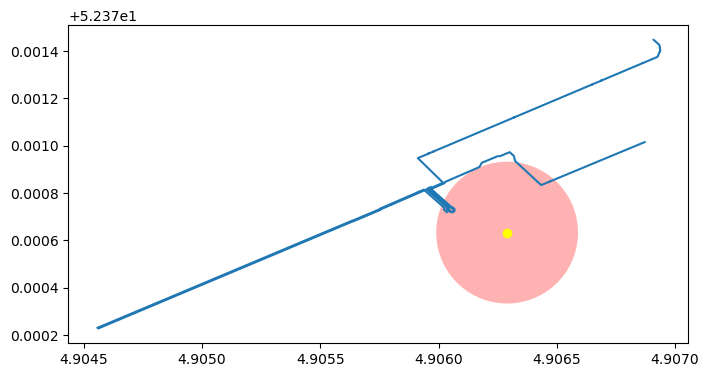

In [256]:
fig, ax = plt.subplots(figsize=(8, 8))

intersected_edges.plot(ax=ax)
gpd.GeoDataFrame({
    'geometry': [destination_buffer]
}).plot(ax=ax, color='red', alpha=.3)

gpd.GeoDataFrame({
    'geometry': [destination.geometry]
}).plot(ax=ax, color='yellow');

In [257]:
intersected_edges

,id,geometry,length,node_start,node_end
11992,493496,"LINESTRING (4.90455 52.37023, 4.90457 52.37024...",0.001649,11752,11835
12220,499920,"LINESTRING (4.90597 52.37083, 4.90595 52.37082...",0.000164,11962,13032
12231,494127,"LINESTRING (4.90691 52.37145, 4.90691 52.37145...",0.001543,11973,11974
12233,108878,"LINESTRING (4.90607 52.37073, 4.90606 52.37072)",0.000009,11974,14799
12251,500852,"LINESTRING (4.90456 52.37023, 4.90456 52.37023...",0.001655,11992,13164
13358,108880,"LINESTRING (4.90605 52.37072, 4.90606 52.37072)",0.000011,13032,14799
13417,500638,"LINESTRING (4.90688 52.37102, 4.90685 52.37101...",0.000728,13107,13123
13418,500900,"LINESTRING (4.90607 52.37073, 4.90607 52.37073...",0.000455,13107,13168
13460,108881,"LINESTRING (4.90605 52.37072, 4.90606 52.37072)",0.000015,13164,14799
14779,108879,"LINESTRING (4.90607 52.37073, 4.90606 52.37072)",0.000013,14799,14800


In [258]:
destination_closest_nodes = [x for x in intersected_edges[['node_start', 'node_end']].values.flatten() if destination_buffer.distance(nodes.loc[x, 'geometry']) == 0]

In [259]:
print(destination_closest_nodes)
print(f'Num candidates as destination: {len(destination_closest_nodes)}')

[11835, 13032, 11974, 11974, 14799, 13164, 13032, 14799, 13168, 13164, 14799, 14799, 14800]
Num candidates as destination: 13


Determine the path

In [260]:
routes_tmp = []
routes_origin = None

for destination_node in destination_closest_nodes:
    try:
        route = nx.shortest_path(G_nx,
                                 source=closest_origin_node_idx,
                                 target=destination_node)

        route_nodes = nodes.loc[route]
        path = LineString(list(route_nodes.geometry.values))
        routes_tmp.append(path)

        if routes_origin:
            route_origin = np.concatenate([routes_origin, edges[(edges.node_start.isin(route_nodes.osmid)) | (edges.node_start.isin(route_nodes.osmid))]])
        else:
            routes_origin = edges[(edges.node_start.isin(route_nodes.osmid)) | (edges.node_start.isin(route_nodes.osmid))].copy()
    except:
        print(f'{closest_origin_node_idx} -> {destination_node}, no path')


if len(routes_tmp) == 0:
    print('routes_tmp is empty')
else:
    routes = gpd.GeoDataFrame(routes_tmp)
    routes.columns = ['geometry']
    routes = routes.set_geometry('geometry')
    routes.crs = edges.crs

11446 -> 11835, no path
11446 -> 11974, no path
11446 -> 11974, no path
11446 -> 14799, no path
11446 -> 13164, no path
11446 -> 13032, no path
11446 -> 14799, no path
11446 -> 13168, no path
11446 -> 13164, no path
11446 -> 14799, no path
11446 -> 14799, no path
11446 -> 14800, no path


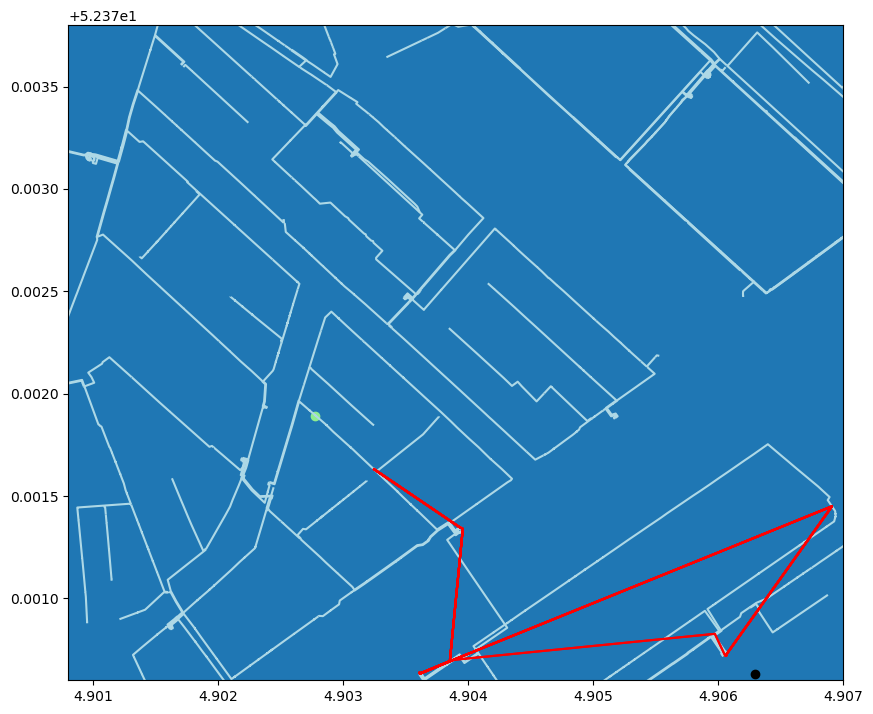

In [261]:
size = 10

fig, ax = plt.subplots(figsize=(size, size))

ax.set_ylim(52.3706, 52.3738)
ax.set_xlim(4.9008, 4.907)

segment_x_netten.plot(ax=ax, color='lightblue')
destination_segments[destination_segments.station == 'OS UILENBURG'].plot(ax=ax)
routes.plot(ax=ax, color='red')
address_gdp.plot(ax=ax, color='lightgreen')
stations[stations.station == 'OS UILENBURG'].plot(ax=ax, color='black');

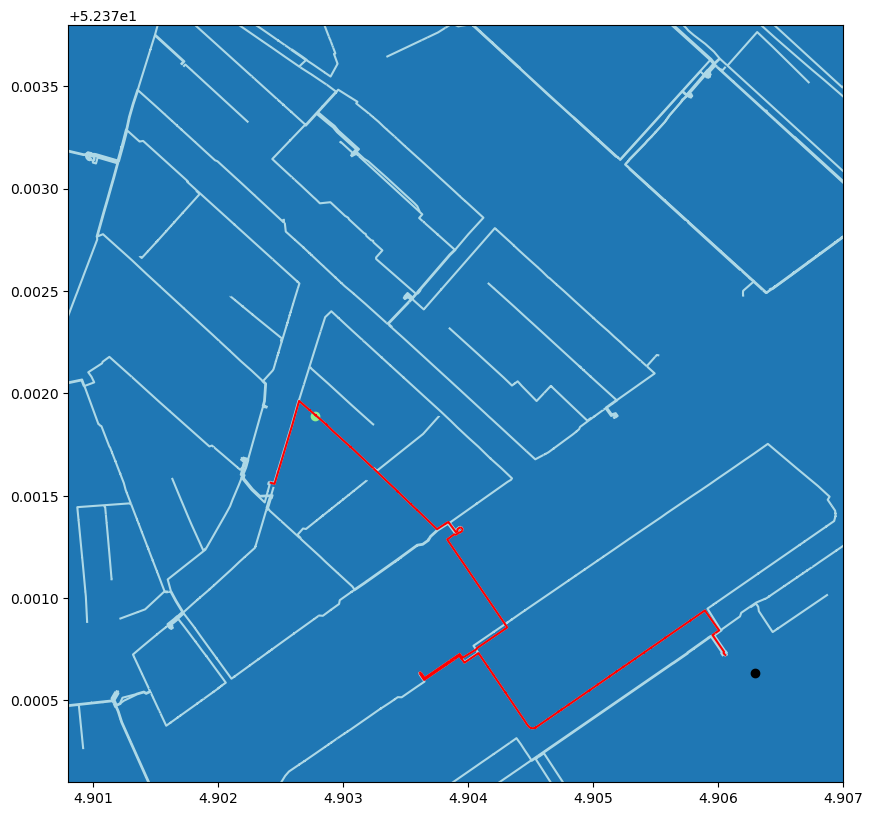

In [262]:
fig, ax = plt.subplots(figsize=(size, size))

ax.set_ylim(52.3701, 52.3738)
ax.set_xlim(4.9008, 4.907)

segment_x_netten.plot(ax=ax, color='lightblue')
destination_segments[destination_segments.station == 'OS UILENBURG'].plot(ax=ax)
routes_origin.plot(ax=ax, color='red')
address_gdp.plot(ax=ax, color='lightgreen')
stations[stations.station == 'OS UILENBURG'].plot(ax=ax, color='black');

In [301]:
d = nx.degree_centrality(G_nx).values()
c = nx.closeness_centrality(G_nx).values()

In [318]:
degrees = [y for _, y in list(nx.degree(G_nx))]

In [302]:
b = nx.betweenness_centrality(G_nx).values()

KeyboardInterrupt: 

In [319]:
v = pd.DataFrame({
    'degrees': degrees,
    'd': d,
    'c': c
})

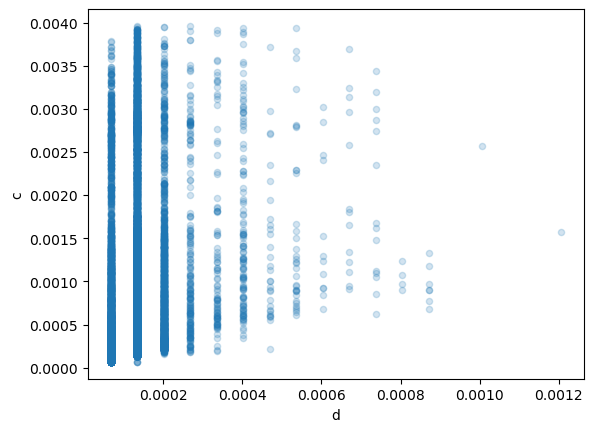

In [320]:
v.plot.scatter(x='d', y='c', alpha=.2);

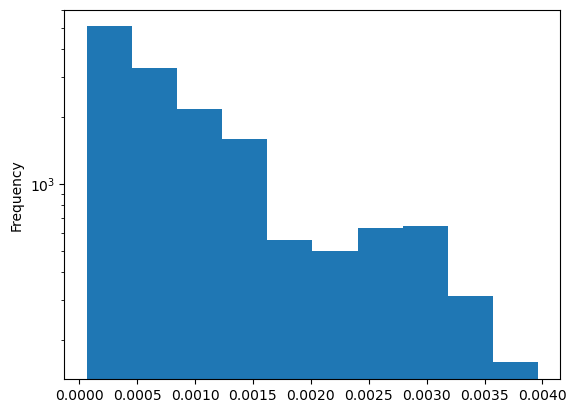

In [337]:
v.c.plot(kind='hist', logy=True);

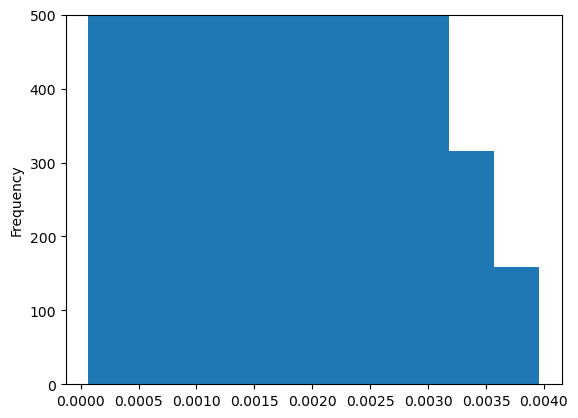

In [336]:
v.c.plot(kind='hist', ylim=(0, 500));

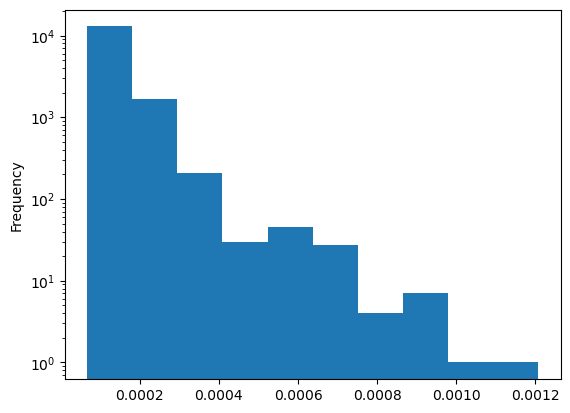

In [338]:
v.d.plot(kind='hist', logy=True);

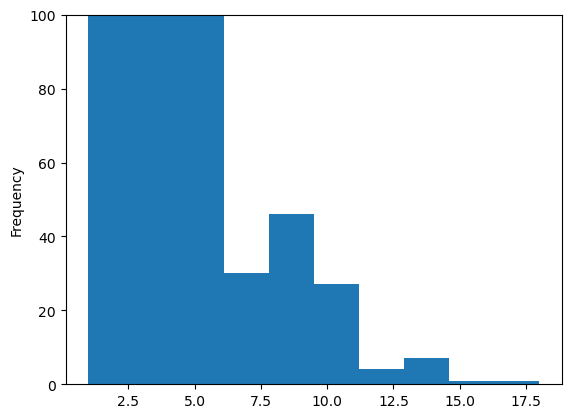

In [327]:
v.degrees.plot(kind='hist', ylim=(0, 100));